# Computer Exercise 1: Estimation and Model Validation
**Time Series Analysis - Lund University - 2025**

This computer exercise treats identification, estimation, and model validation in ARMA- and SARIMA-processes. The focus is on simulating different kinds of stationary and non-stationary time series, and on how one may then identify a suitable model structure mainly using the autocorrelation function (ACF) and the partial autocorrelation function (PACF). In the exercise, we will examine both simulated and measured time series data.

## 1. Preparations before the exercise

Read Chapter 3 and 4 in the course textbook as well as this guide to the computer exercise. Solve the problem exercises 3.6, 3.10, 4.3, 4.4, and 5.2 in the book. Answers to some of the computer exercise will be graded using the course's **Mozquizto** page.

Ensure that you can access the system before the exercise and answer the preparatory questions as well as (at least) three of numbered exercise questions below **before the exercise**.

You can find the **Mozquizto** system at: `https://quizms.maths.lth.se`

It should be stressed that a thorough understanding of the material in this exercise is important to be able to complete the course project, and we encourage you to discuss any questions you might have on the exercises with the teaching staff. This will save you a lot of time when you start working with the project!

You are allowed to solve the exercise in groups of two, but not more. Please respect this.




## 2. Tasks

The computer program Python and functions from the course Python package will be used: `https://github.com/andreasjak/TimeSeriesAnalysis`

**Important:** In the following, we will make use of various Python functions from the tsa_lth library.

**Hint:** Create separate functions for different subtasks, you will likely need to use the same code several times, and this both saves time and helps you to debug your code efficiently.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
import os
import importlib
import scipy.io

# Add path to tsa_lth library
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main')))

# Import and reload to get the latest changes
import tsa_lth.analysis
import tsa_lth.modelling
import tsa_lth.tests
importlib.reload(tsa_lth.analysis)
importlib.reload(tsa_lth.modelling)
importlib.reload(tsa_lth.tests)

from tsa_lth.analysis import plotACFnPACF, normplot, xcorr, pzmap, kovarians
from tsa_lth.modelling import estimateARMA, polydiv
from tsa_lth.tests import whiteness_test, check_if_normal


## 2.1 Working with time series

In this first section, we will work with two sets of A- and C-polynomials, the first set being:

```python
A1 = [1, -1.79, 0.84]
C1 = [1, -0.18, -0.11]
```

and the second set:

```python
A2 = [1, -1.79]
C2 = [1, -0.18, -0.11]
```

These polynomials builds an ARMA-process of the form

$$A(z) y_t = C(z) e_t$$

In [2]:
# Define the two ARMA models
A1 = np.array([1, -1.79, 0.84])
C1 = np.array([1, -0.18, -0.11])

A2 = np.array([1, -1.79])
C2 = np.array([1, -0.18, -0.11])


An easy way to simulate an ARMA-process

$$y_t=\frac{C(z)}{A(z)}e_t$$

in Python is to use the `signal.lfilter` function. The function needs the $A(z)$ and $C(z)$ polynomials as well as the driving noise process to generate a simulation. To allow for easy comparison with the values used in the **Mozquizto** system, set the random seed using

```python
np.random.seed(0)
```

Then, generate some normal distributed noise with the command

```python
e = np.sqrt(sigma2) * np.random.randn(N)
```

where `sigma2` is the variance of the noise process `e`, and `N` is the length of the resulting vector.

After creating the noise vector, you simulate the ARMA process with the command:
```python
y = signal.lfilter(C, A, e)
```

**Important:** When simulating a process containing an AR part, such as an AR or ARMA process, the initial values in the simulated signals will behave differently to the latter values as these are not initiated by earlier values being a part of the process, but with zeros (by default $y_0 = y_{-1}=\ldots=0$). These will in turn affect the following samples, and so on, with diminishing influence the further you go. As a result, the initial simulated samples will behave somewhat differently from what one expects from the simulated process.

A simple way to handle this is to just simulate a longer process than needed, and then omitting the initial samples. Often, one use a significant "buffer" in this way to avoid any unwanted initial effects to affect the following samples, preferring to exaggerate the number of omitted samples (obviously, this is only done when simulating signals). For almost all simulated processes, one may safely assume that any initial effects will be negligible after, say, 100 samples (and, typically, well before this).

**Hint:** It is recommended that you create your own function for simulating data, say `simulate_ARMA()`, that takes the specified parameters as input, as well as the desired data length, and then returns the simulated data. Internally, the function then simulates a longer signal, say 100 samples longer, and then just returns the signal from the end of the simulated signal. By doing this, you will ensure that it is easy for you to simulate new data, and that you do not forget to handle the initial data effects when doing so (this easily happens...).

Now simulate `300` samples of the ARMA processes and omit the first 100 samples of each. Proceed to simulate the `y1` and `y2` processes, using `sigma2=1.5`. Plot the two processes using subplots.

In [3]:
def simulate_ARMA(A, C, sigma2=1.5, N=300, buffer=100, seed=0):
    if seed is not None:
        np.random.seed(seed)
    e = np.sqrt(sigma2) * np.random.randn(N + buffer)
    y = signal.lfilter(C, A, e)
    return y[buffer:]


y1 = simulate_ARMA(A1, C1, sigma2=1.5, N=300, buffer=100, seed=0)

y2 = simulate_ARMA(A2, C2, sigma2=1.5, N=300, buffer=100, seed=1)


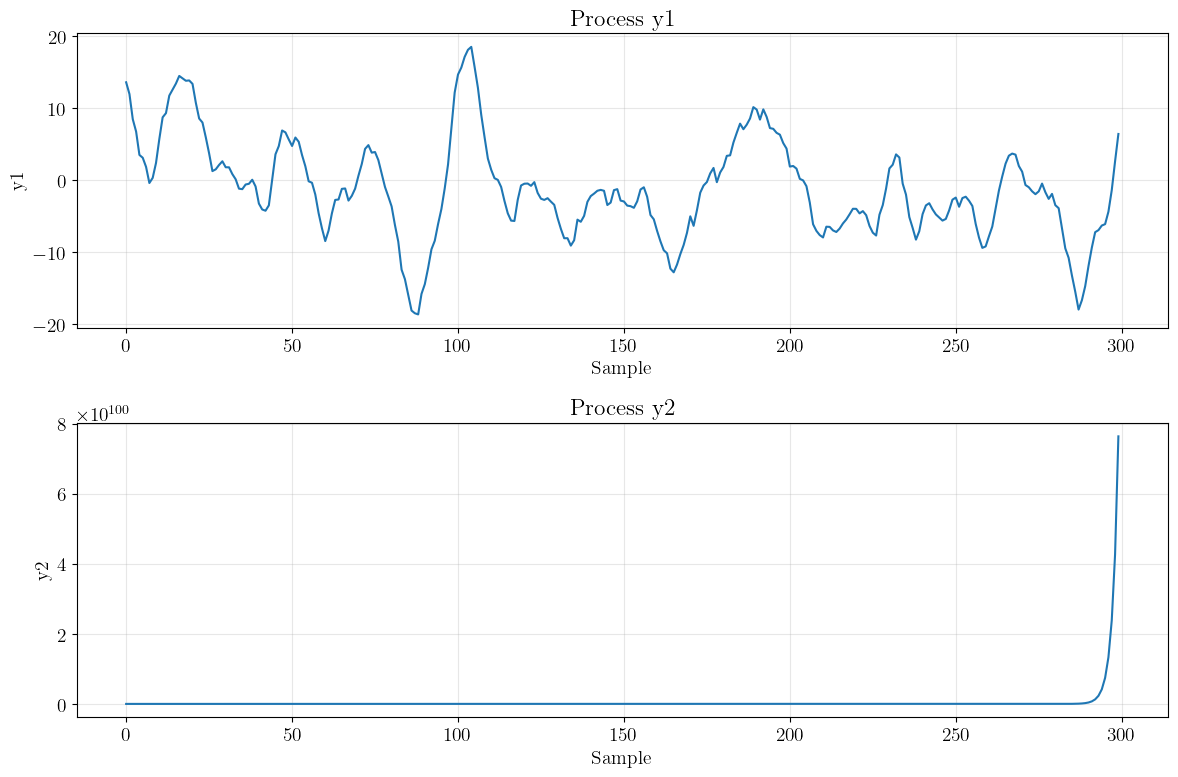

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(y1)
ax1.set_title('Process y1')
ax1.set_xlabel('Sample')
ax1.set_ylabel('y1')
ax1.grid(True, alpha=0.3)

ax2.plot(y2)
ax2.set_title('Process y2')
ax2.set_xlabel('Sample')
ax2.set_ylabel('y2')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Analyzing the processes

As you can see, one of the processes diverges. Why is that? 

Plot the poles and zeros of the different polynomials to see if this provides a clue.

**QUESTION 1:** In Mozquizto, answer question 1.


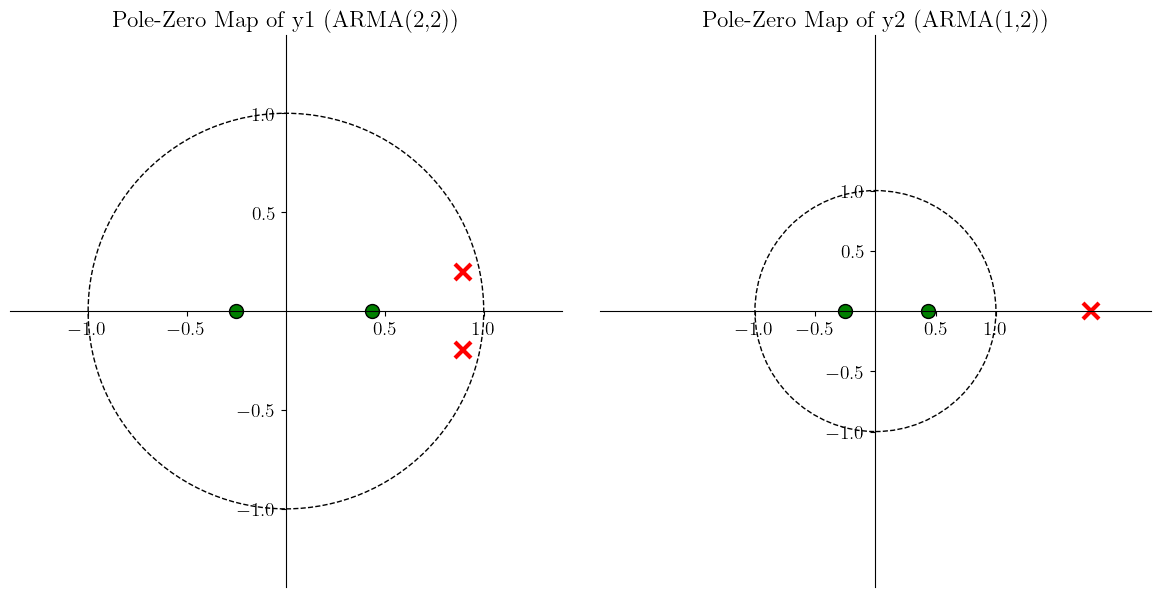

In [5]:
# Plot pole-zero maps to analyze why one process diverges
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
pzmap(C1, A1, ax=ax1, show=False)
ax1.set_title('Pole-Zero Map of y1 (ARMA(2,2))')

pzmap(C2, A2, ax=ax2, show=False)
ax2.set_title('Pole-Zero Map of y2 (ARMA(1,2))')

plt.tight_layout()
plt.show()


### Covariance function comparison

The theoretical covariance function $r_y(k)$ for an ARMA-process can be computed using the Yule-Walker equations using the provided function `kovarians`. 

The function assumes that the driving noise process has unit variance, i.e., $V(e(t)) = \sigma^2 = 1$. 

To instead compute the estimated covariance from a given data set, use the function `xcorr`.

Plot to compare the theoretical versus the estimated covariance for `y1` (set `m=20`).

Why are the estimated and theoretical covariance functions not identical?

**QUESTION 2:** In Mozquizto, answer question 2.

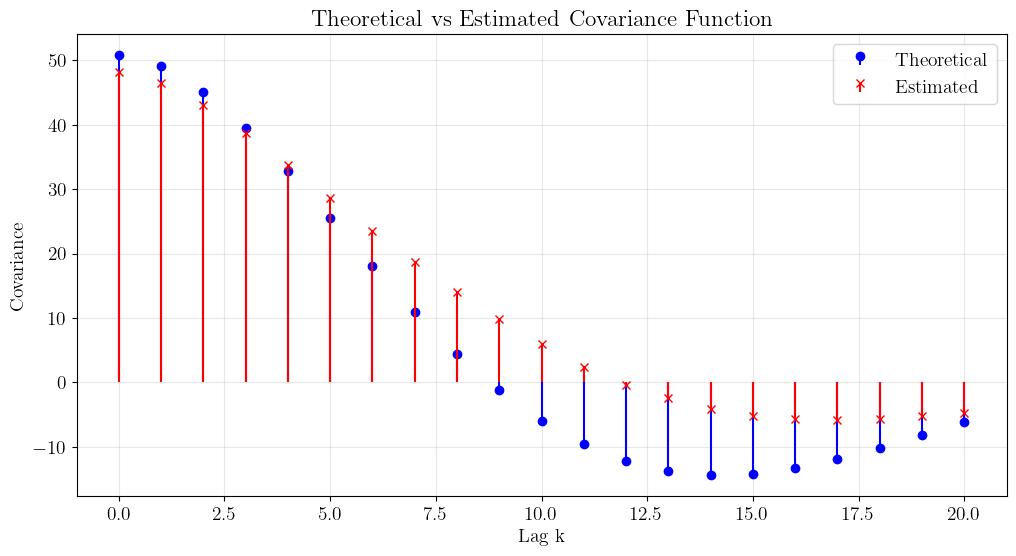

In [6]:
m = 20  # Number of lags to compute


sigma2 = 1.5
r_theo, tau = kovarians(C1, A1, m)
r_theo = r_theo * sigma2  # Scale by actual noise variance

# Compute estimated covariance from data using
lags, r_est = xcorr(y1, maxlag=m, biased=True)
r_est = r_est[m:]  

# Plot comparison
plt.figure(figsize=(12, 6))
plt.stem(tau, r_theo, linefmt='b-', markerfmt='bo', basefmt=' ', label='Theoretical')
plt.stem(tau, r_est, linefmt='r-', markerfmt='rx', basefmt=' ', label='Estimated')
plt.xlabel('Lag k')
plt.ylabel('Covariance')
plt.title('Theoretical vs Estimated Covariance Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Model estimation and validation

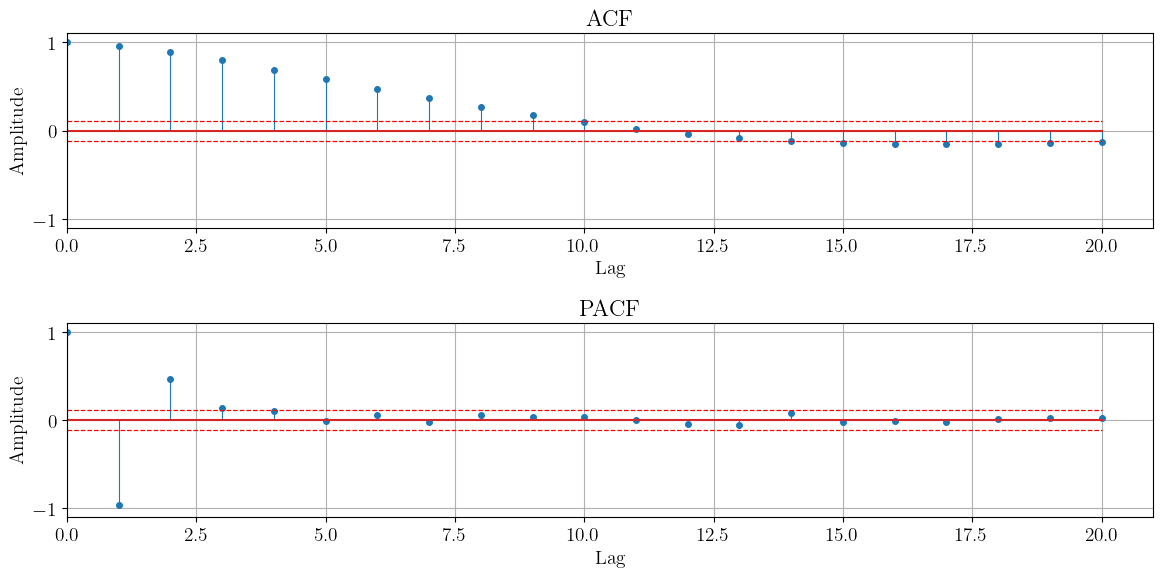

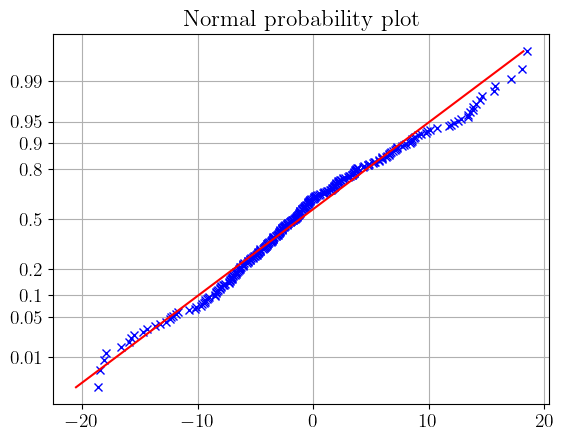

In [7]:
# Basic analysis of y1 using ACF, PACF, and normplot take a look on how plotACFnPACF() and normplot() is implemented in analysis.py: 
plotACFnPACF(y1)
normplot(y1)

Estimate the model you wish to validate using the LS-based method for an AR($n_a$) model or using the ML-based method for an ARMA($n_a$, $n_c$) model. 

For estimation, Python uses the `estimateARMA` function which can estimate both AR and ARMA models by specifying the model orders.

To calculate the error residual of your estimated model, you can filter your data through the inverse filter of your model using:

```python
e_hat = signal.lfilter(model.A, model.C, y)
```

**Important:** An important thing to note when computing the residual using filtering is that the initial values of the output will be corrupted, as the AR part will need non-existing samples to initialise the first states, therefore setting these to zeros. 

This means that the first $n_a$ samples will be corrupted and should **always** be removed before **any** further processing is done.

Try changing the order of the $A(z)$ polynomial and plot the first 20 samples of `e_hat`. Can you see that the initial $n_a$ samples are corrupted? 

To avoid this from causing problems for you, you should **always** remove the first $n_a$ samples when filtering any process that you are modelling.

**Hint:** As you will do the filtering operation many times, and it is very easy to forget omitting these $n_a$ initial samples, it is highly recommended that you create your own function `my_filter` that does the filtering and omits the samples; that way you will not forget this. 

It is only a couple of lines of code, but it will likely save you a lot of pain... However, also note that there are cases when you do not want to do this automatically, especially in the case of prediction that we will cover later - in that case, you will filter two different sequences with different lengths - and then want omit the same number of samples as the longer filter for both sequences. In this case, you do **not** want to use `my_filter`.

In [10]:
def my_filter(A, C, y):
    e_hat = signal.lfilter(A, C, y)
    na = A.size - 1
    return e_hat[na:]

### Demonstration of Initial Sample Corruption

Let's examine the issue with initial sample corruption when filtering. 

We'll compare filtering with and without removing the initial corrupted samples. Notice that the initial residuals are high.

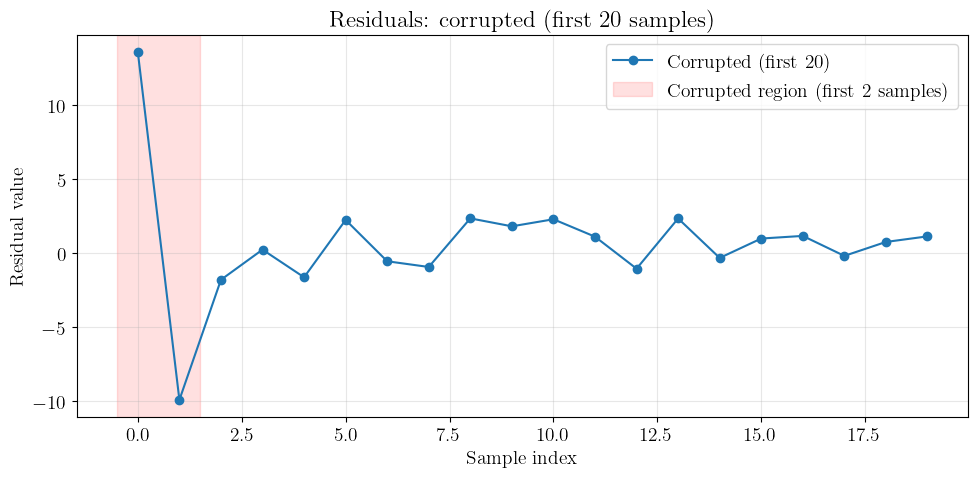

In [11]:
A_demo = np.array([1, -1.79, 0.84])
C_demo = np.array([1, -0.18, -0.11])

e_hat_corrupted = signal.lfilter(A_demo, C_demo, y1)

e_hat_clean = my_filter(A_demo, C_demo, y1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(20), e_hat_corrupted[:20], 'o-', markersize=6, color='C0', label='Corrupted (first 20)')
na = len(A_demo) - 1
plt.axvspan(-0.5, na - 0.5, alpha=0.12, color='red', label=f'Corrupted region (first {na} samples)')
plt.xlabel('Sample index')
plt.ylabel('Residual value')
plt.title('Residuals: corrupted (first 20 samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Finding the appropriate model order

Proceed to find an appropriate model for the process by adding one extra parameter at a time, and then analyze the residual using ACF, PACF, and normplot. 

Make a note of the FPE for each of the models you examine. Is the FPE minimized for the correct model order?

AR(1) - A: [ 1.         -1.63655448  0.68354539], FPE: 1.4460

AR(1) Residual Analysis:


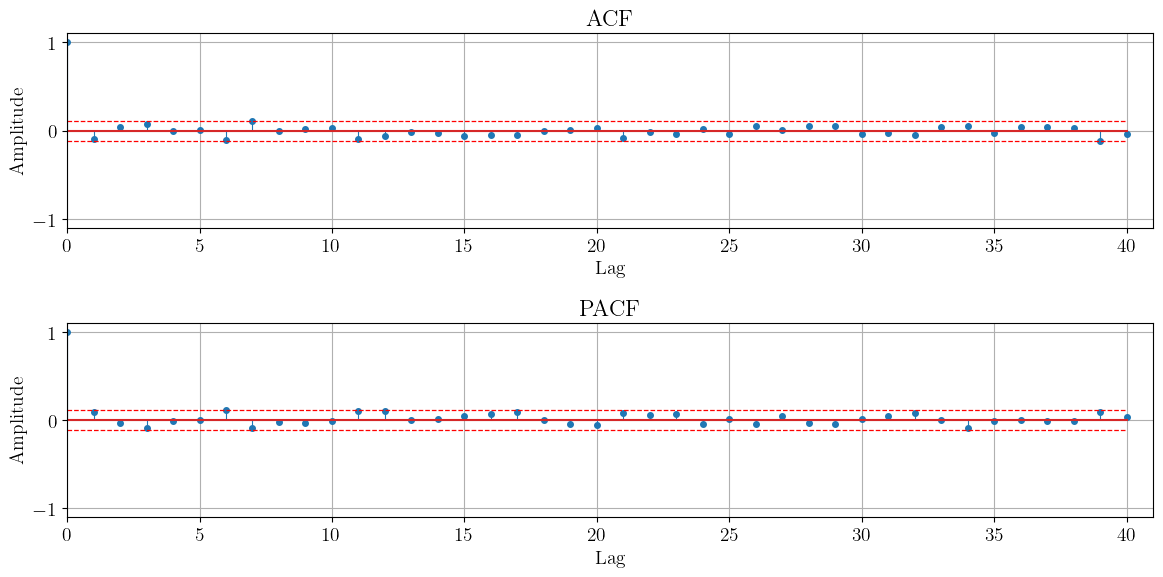

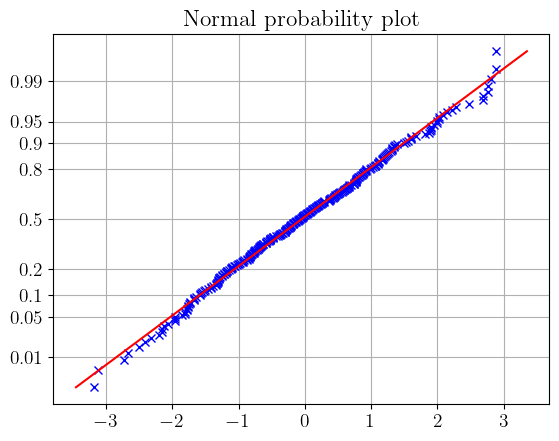

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 23.09 < 37.65)
  McLeod-Li test:        True (white if 22.03 < 37.65)
  Monti test:            True (white if 30.93 < 37.65)
  Sign change test:      True (white if 0.51 in [0.44,0.56])


In [12]:
# Estimate AR model different orders


ar1_model = estimateARMA(y1, A=2, C=0, plot=False)
e_hat_ar1 = my_filter(ar1_model.A, ar1_model.C, y1)
print(f"AR(1) - A: {ar1_model.A}, FPE: {ar1_model.FPE:.4f}\n")

# Analyze AR(1) residuals (best AR model based on PACF)
print("AR(1) Residual Analysis:")
plotACFnPACF(e_hat_ar1, noLags=40, signLvl=0.05)
normplot(e_hat_ar1)
whiteness_test(e_hat_ar1, alpha=0.05)

# test other AR models


### Estimating ARMA Models

Now let's estimate ARMA models with different combinations of $n_a$ and $n_c$.

Estimating ARMA(1,1)...
ARMA(1,1) - A: [ 1.         -1.63655448  0.68354539], C: [1.]
FPE: 1.4460

ARMA(1,1) Residual Analysis:


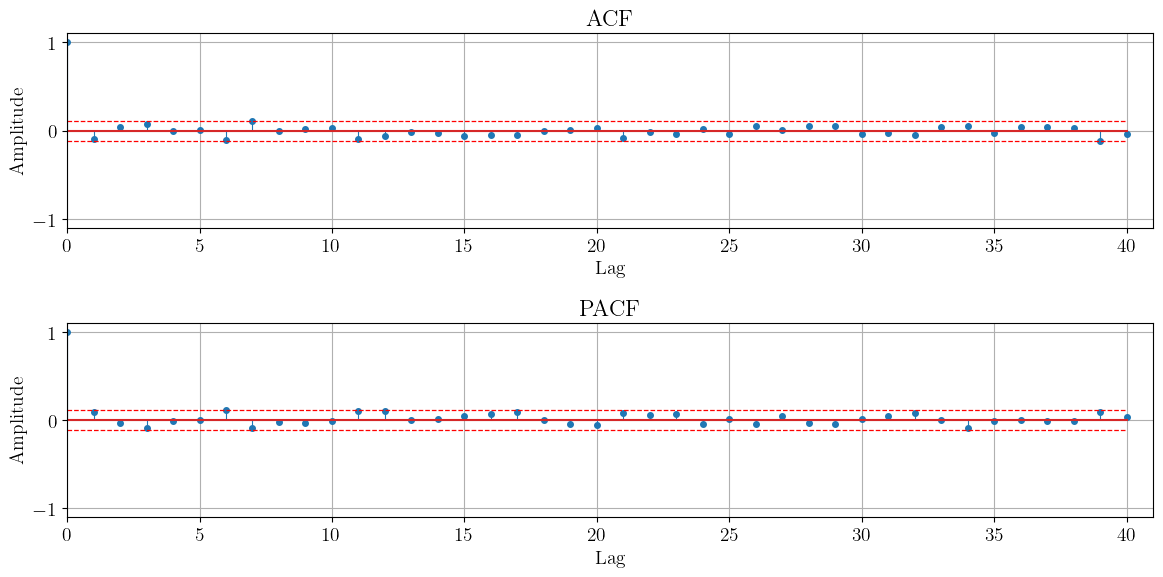

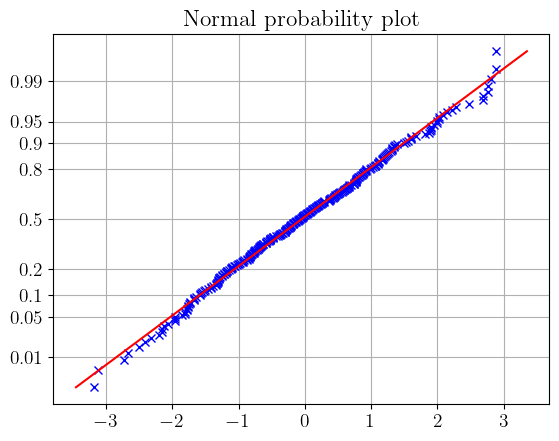

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 23.09 < 37.65)
  McLeod-Li test:        True (white if 22.03 < 37.65)
  Monti test:            True (white if 30.93 < 37.65)
  Sign change test:      True (white if 0.51 in [0.44,0.56])


In [13]:
# Estimate ARMA model 

# ARMA(1,1)
print("Estimating ARMA(1,1)...")
arma11_model = estimateARMA(y1, A=2, C=0, plot=False)
e_hat_arma11 = my_filter(arma11_model.A, arma11_model.C, y1)
print(f"ARMA(1,1) - A: {arma11_model.A}, C: {arma11_model.C}")
print(f"FPE: {arma11_model.FPE:.4f}\n")

# Analyze ARMA(1,1) residuals
print("ARMA(1,1) Residual Analysis:")
plotACFnPACF(e_hat_arma11, noLags=40, signLvl=0.05)
normplot(e_hat_arma11)
whiteness_test(e_hat_arma11, alpha=0.05)

# test other ARMA models


### Examination Question 3

**QUESTION 3:** In Mozquizto, answer question 3.

## 2.2 Model order estimation of an ARMA-process

In the file `data.dat` you will find 200 observations of the ARMA(1,1)-process

$$y_t - 0.6 y_{t-1} = e_t + 0.8 e_{t-1}$$

Assuming that you do not know what might be an appropriate model structure for the process, we will begin by trying to estimate it using an AR($p$) model, for $p=1,\ldots,5$. 

When examining which model order to use, see the parameter estimates and some statistics. 

Try modelling data as an AR($p$) model, for $p=1,\ldots,5$.

Data shape: (200,)
Number of observations: 200


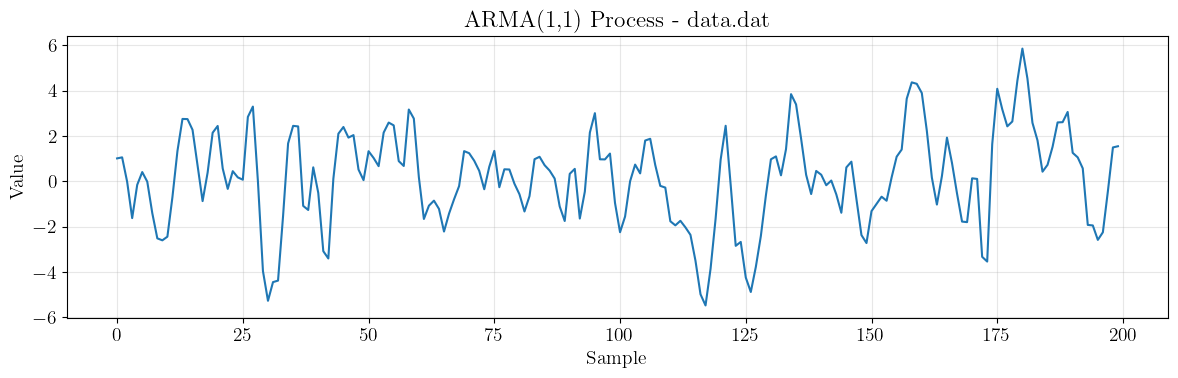

In [14]:
# Load the data from data.dat
data = np.loadtxt('../data/data.dat')
orig_noise = np.loadtxt('../data/noise.dat')

print(f"Data shape: {data.shape}")
print(f"Number of observations: {len(data)}")

# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(data)
plt.title('ARMA(1,1) Process - data.dat')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Try AR($p$) models for $p = 1, \ldots, 5$

To get useful information about the model, try using `.summary()`.

AR(1) Model
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.2952(±0.0678)·z⁻¹ + 0.8365(±0.098)·z⁻² - 0.306(±0.0681)·z⁻³

Polynomial orders: nA = 3
Number of free coefficients: 3
Fit to estimation data (NRMSE): 46.62%
FPE : 1.262  MSE : 1.226
AIC : 605.172   BIC : 615.022


AR(1) Residual Analysis:


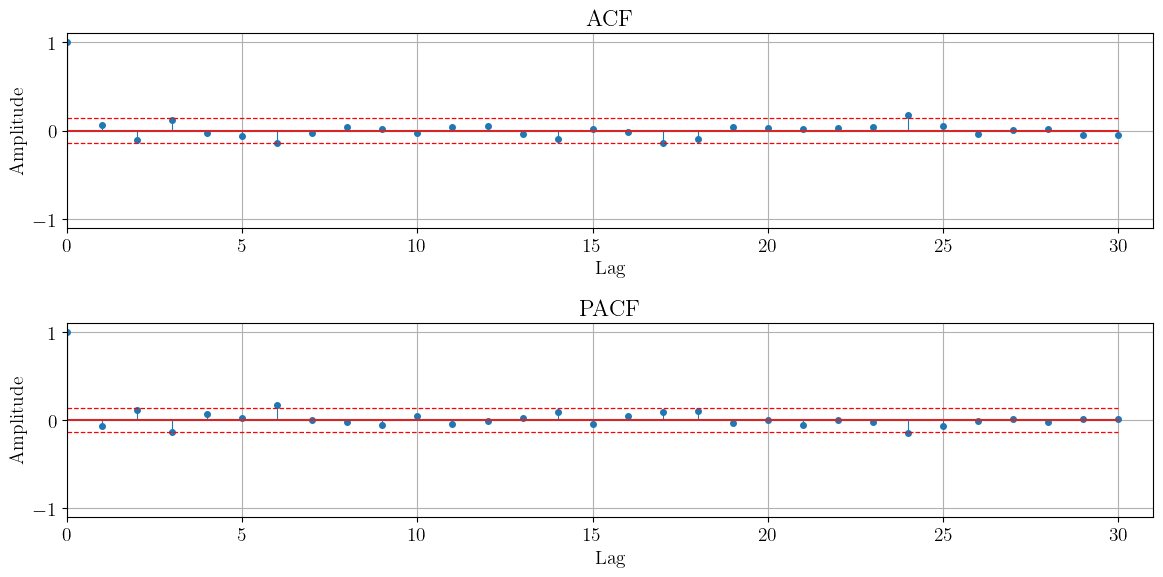

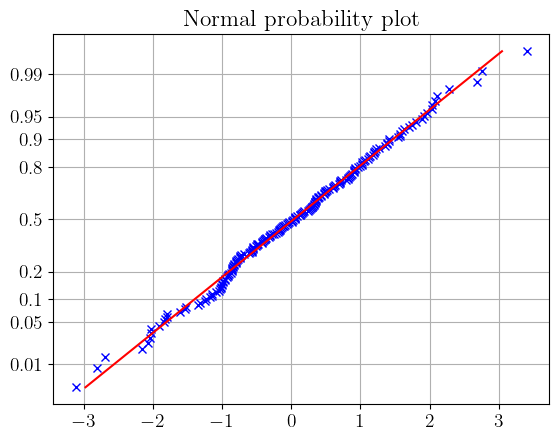

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 29.98 < 37.65)
  McLeod-Li test:        True (white if 20.36 < 37.65)
  Monti test:            True (white if 29.04 < 37.65)
  Sign change test:      True (white if 0.46 in [0.43,0.57])


In [18]:
# AR(1) model
print("=" * 60)
print("AR(1) Model")
print("=" * 60)
ar1_model = estimateARMA(data, A=3, C=0, plot=False)
ar1_model.summary()

# Compute residuals
e_hat_ar1 = my_filter(ar1_model.A, ar1_model.C, data)

# Analyze residuals
print("\nAR(1) Residual Analysis:")
plotACFnPACF(e_hat_ar1, noLags=30, signLvl=0.05)
normplot(e_hat_ar1)
whiteness_test(e_hat_ar1, alpha=0.05)

# test other AR models

### Examination Question 4

**In Mozquizto, answer question 4.**

### Try ARMA($p,q$) models

Instead, try to model the data using ARMA($p,q$) models, for $p,q = 1, 2$.

ARMA(1,1) Model
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.5815(±0.0618)·z⁻¹
C(z) = 1.0 + 0.7637(±0.0492)·z⁻¹

Polynomial orders: nA = 1    nC = 1
Number of free coefficients: 2
Fit to estimation data (NRMSE): 48.09%
FPE : 1.182  MSE : 1.159
AIC : 598.115   BIC : 604.702


ARMA(1,1) Residual Analysis:


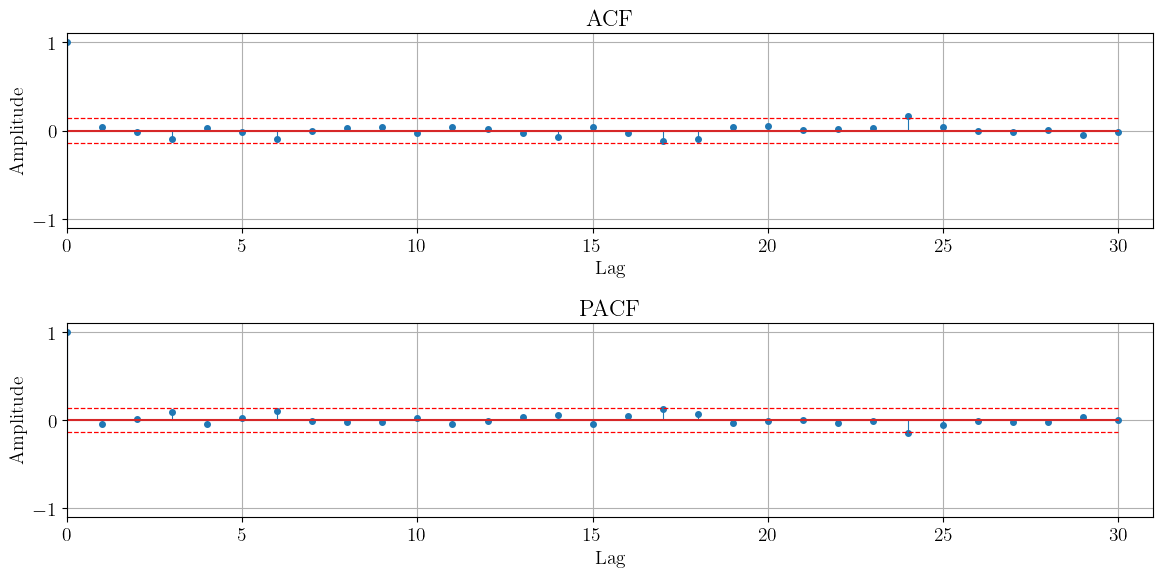

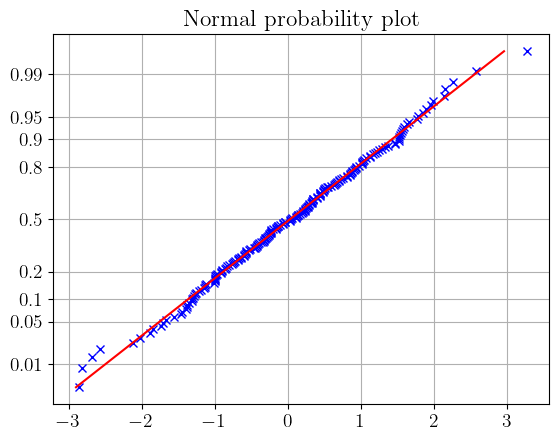

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.88 < 37.65)
  McLeod-Li test:        True (white if 21.87 < 37.65)
  Monti test:            True (white if 18.27 < 37.65)
  Sign change test:      True (white if 0.49 in [0.43,0.57])


In [23]:
# ARMA(1,1) model
print("=" * 60)
print("ARMA(1,1) Model")
print("=" * 60)
arma11_model = estimateARMA(data, A=1, C=1, plot=False)
arma11_model.summary()

# Compute residuals
e_hat_arma11 = my_filter(arma11_model.A, arma11_model.C, data)

# Analyze residuals
print("\nARMA(1,1) Residual Analysis:")
plotACFnPACF(e_hat_arma11, noLags=30, signLvl=0.05)
normplot(e_hat_arma11)
whiteness_test(e_hat_arma11, alpha=0.05)

# Test other ARMA models

### Discussion: Model comparison

Comparing the models using the variance of the residuals, which was the best model of the ones you considered, i.e., an AR($p$), for $p=1,\ldots,5$, or an ARMA($p,q$), for $p,q = 1, 2$? 

Examine the ACF and PACF as well. 

Which model would you pick if you did not know it was an ARMA(1,1)?

**Be prepared to answer this question when discussing with the examiner at the computer exercise!**

## 2.3 Estimation of a SARIMA-process

We proceed to examine the seasonal ARMA model

$$
A(z)\nabla_s y_t = C(z)e_t,
$$

with $\nabla_s = (1-z^{-s})$.

We begin with simulating data, and then use the ML-based estimator to re-estimate the parameters to see how this is done. Simulate the process using the following polynomials:

$$
A(z) = 1 - 1.5z^{-1} + 0.7z^{-2},
$$

$$
C(z) = 1 - 0.5z^{-12},
$$

and

$$
A_{12}(z) = \nabla_{12} = (1 - z^{-12}),
$$

and form the polynomial

$$
A^\star(z) = A(z)A_{12}(z).
$$

We here set the seed just to get the same result as used in Mozquizto. Simulate 600 samples (100 samples should be removed to avoid initial corruption).

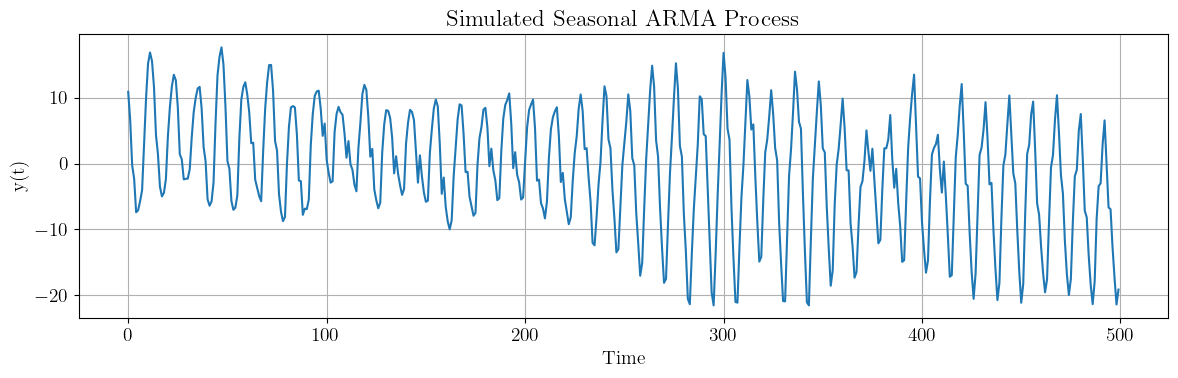

In [41]:
# Define the polynomials
np.random.seed(0)
A = np.array([1, -1.5, 0.7])
C = np.array([1] + [0]*11 + [-0.5])  # [1, 0, 0, ..., 0, -0.5] with 12 zeros
A12 = np.array([1] + [0]*11 + [-1])  # [1, 0, 0, ..., 0, -1] with 12 zeros

A_star = np.convolve(A, A12)


# Simulate the process
N = 500
buffer = 100
y = simulate_ARMA(A_star, C, sigma2=1.0, N=N, buffer=buffer)

# Plot the simulated data
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title('Simulated Seasonal ARMA Process')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.grid(True)
plt.tight_layout()
plt.show()



### Basic analysis

Perform basic analysis of the signal using ACF, PACF, and normplot. What characteristics does it have?

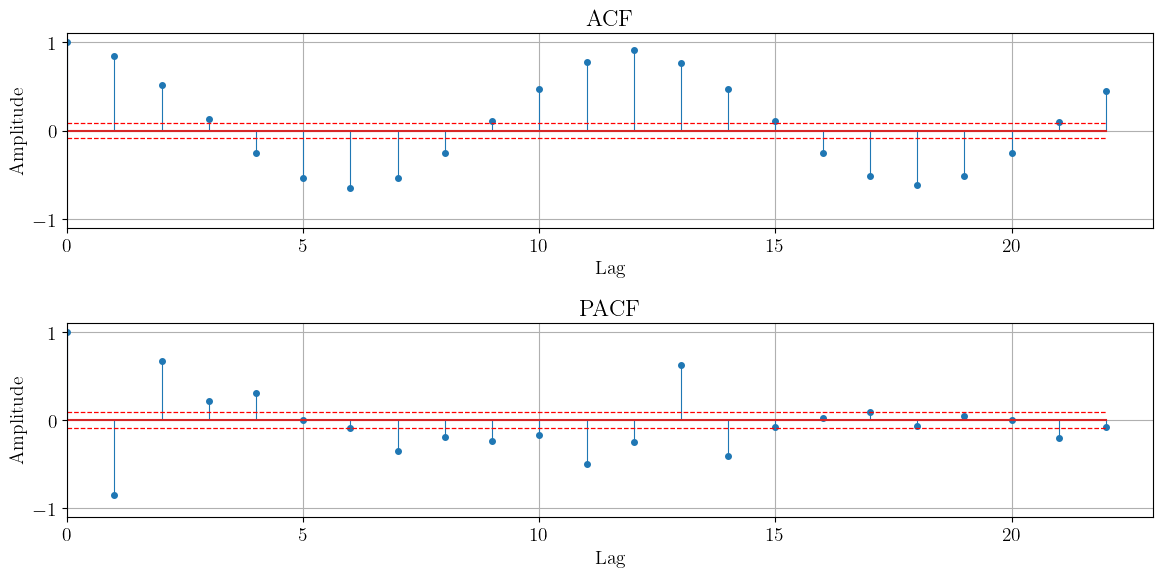

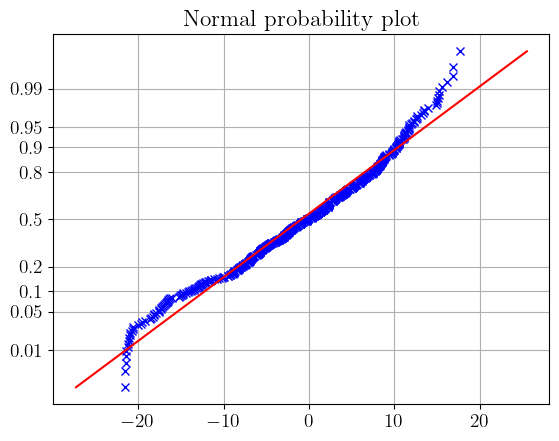

In [42]:
# do some basic analysis on the data
plotACFnPACF(y)
normplot(y)

The ringing behaviour you see in both the ACF and the PACF indicates strong seasonality. To be able to model the process taking the season into account, you create a differentiated process.

### Remove the seasonal component

To do so, start by removing the season by filtering the data with $A_{12}(z) = (1 - z^{-12})$.

**Note:** We again have to omit the initial samples - otherwise these initial corrupt samples will harm our continuing processing!

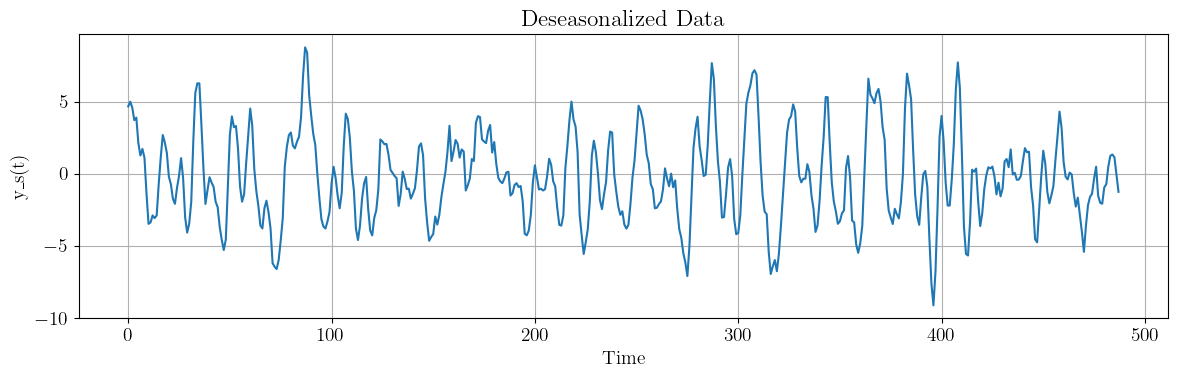

In [43]:
### Estimate an AR(2) model
C = np.array([1])
A12 = np.array([1] + [0]*11 + [-1])
y_s = my_filter(A12, C, y)

# Building a model to this data, one parameter at a time, could for instance mean starting with an AR(2) model. Use the estimator to estimate $a_1$ and $a_2$.
# Plot the deseasonalized data
plt.figure(figsize=(12, 4))
plt.plot(y_s)
plt.title('Deseasonalized Data')
plt.xlabel('Time')
plt.ylabel('y_s(t)')
plt.grid(True)
plt.tight_layout()
plt.show()

Building a model to this data, one parameter at a time, could
for instance mean starting with an AR(1), as an initial guess, redo the basic
analysis and then proceed to an AR(2)

ARMA(2,1) Model
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 1.4319(±0.049)·z⁻¹ + 0.6607(±0.046)·z⁻²
C(z) = 1.0 + 0.0525(±0.0651)·z⁻¹

Polynomial orders: nA = 2    nC = 1
Number of free coefficients: 3
Fit to estimation data (NRMSE): 63.69%
FPE : 1.246  MSE : 1.235
AIC : 1487.755   BIC : 1500.314


ARMA(1,1) Residual Analysis:


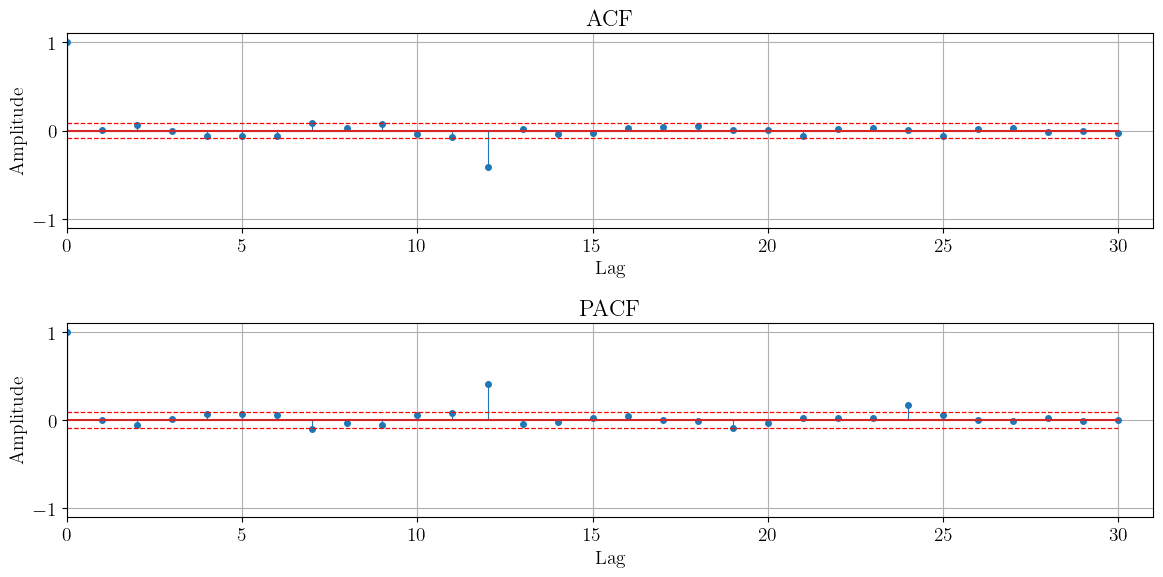

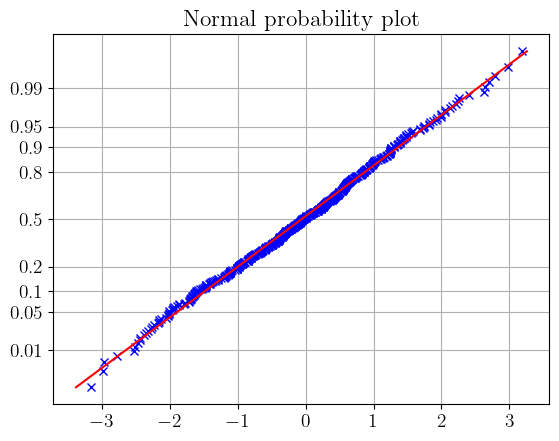

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 106.68 < 37.65)
  McLeod-Li test:        True (white if 29.52 < 37.65)
  Monti test:            False (white if 123.47 < 37.65)
  Sign change test:      True (white if 0.52 in [0.46,0.54])


In [44]:
# create a simple model for the data 
A = 2
C = 1
print("=" * 60)
print(f"ARMA({A},{C}) Model")
print("=" * 60)
arma_model = estimateARMA(y_s, A=A, C=C, plot=False)
arma_model.summary()

# Compute residuals
e_hat_arma = my_filter(arma_model.A, arma_model.C, y_s)

# Analyze residuals
print("\nARMA(1,1) Residual Analysis:")
plotACFnPACF(e_hat_arma, noLags=30, signLvl=0.05)
normplot(e_hat_arma)
whiteness_test(e_hat_arma, alpha=0.05)

Form the residual and plot its ACF and PACF. What characteristics does it have?

### Add MA(12) component

To add a single parameter of a higher order, i.e., to set some parameters fixed to a value, we specify which C coefficients are free to be estimated. 

For the C-polynomial, we have thus made all parameters fixed except for $c_{12}$. Include this parameter in the model and estimate $a_1$, $a_2$, and $c_{12}$.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 1.4523(±0.0331)·z⁻¹ + 0.6763(±0.033)·z⁻²
C(z) = 1.0 - 0.466(±0.0397)·z⁻¹²

Polynomial orders: nA = 2    nC = 12
Number of free coefficients: 3
Fit to estimation data (NRMSE): 67.25%
FPE : 1.005  MSE : 1.005
AIC : 1387.555   BIC : 1400.114



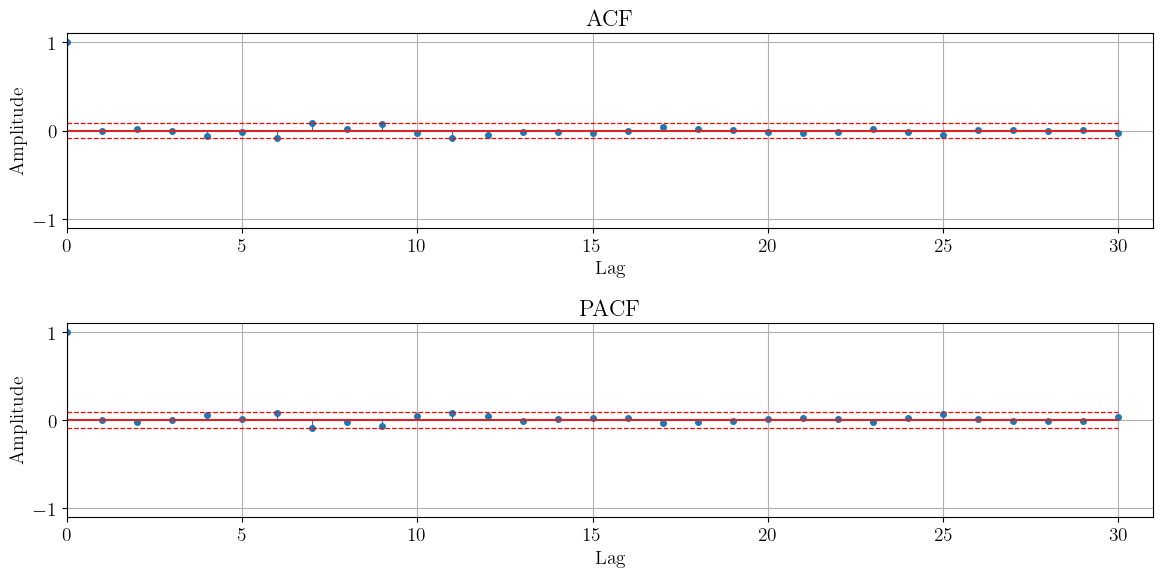

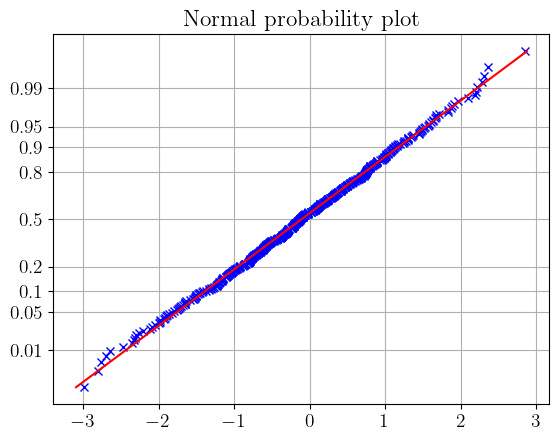

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 20.44 < 37.65)
  McLeod-Li test:        True (white if 32.88 < 37.65)
  Monti test:            True (white if 22.81 < 37.65)
  Sign change test:      True (white if 0.46 in [0.46,0.54])


In [45]:
# Estimate ARMA(2, 12) with only c_12 free (c_1 through c_11 fixed at 0)
# We specify which C coefficients are free to be estimated
C_free = np.array([1] + [0]*11 + [1])  # c_0 and c_12 are free (c_0 is always 1)

model_arma = estimateARMA(y_s, A=2, C=12, C_free=C_free, plot=False)
model_arma.summary()

# Compute residuals
e_hat_arma = my_filter(model_arma.A, model_arma.C, y_s)

# Analyze residuals
plotACFnPACF(e_hat_arma, noLags=30, signLvl=0.05)
normplot(e_hat_arma)
whiteness_test(e_hat_arma, alpha=0.05)

### Model quality

The main questions to ask are now:

- Did this remove the season of the resulting model residual?
- Is the residual white noise?
- Are the ACF and/or PACF coefficients Gaussian distributed so that you can trust your whiteness test?
- Are the estimated parameters significant?

Compare the estimated parameters with the values used to simulate the process. 

Examine how the quality of the estimates improve if you redo the simulation but instead using $N=10000$ samples.

### Examination Question 5

**In Mozquizto, answer question 5.**

### Modelling steps summary

In summary, the typical modelling steps used when constructing a time series model generally works in accordance with the following steps:

1. Is there a trend? Try removing it.
2. Is there any seasonality? Try removing it.
3. Iterate between
   - (a) Which is the lowest order strong AR- or MA-component? Try removing it by including it in the model. Always begin with the strongest AR-component, then inspect the MA-components in the next iteration.
   - (b) Is the residual white noise? If not, go to (a). Can you trust your test, i.e., is the ACF and/or PACF Gaussian distributed? If not, what are the consequences? Should you allow for more parameters?
4. Are all parameter estimates statistically significant? If not, redo the analysis and use a different model structure.

### Hint: Testing with simulated data

**Hint:** If (or, rather, when) you want to check that your code is correct, it is always wise to test it using simulated data, preferably using a lot of samples. 

Simply simulate a process that has roughly the same characteristics as the process you are examining (typically using the model you have estimated) and check that your code predicts the simulated process well. 

For a long sequence, it should work, otherwise, there is most likely a bug somewhere... 

It is highly recommended that you **always** do this when modelling data!

### Discussion: Incorporating differentiation

Can you improve your model by not removing the trend and/or season separately, but rather incorporating these parts in your model and estimate the corresponding coefficients? 

That is, do you get better result if you include the differentiation in your $A(z)$ polynomial? Try it out!

**Question:** Can you incorporate the differentiation $\nabla_{12}$ in the model $A(z)$ instead of first removing the season?

Is the resulting model better in some sense, i.e., is the variance of the model residual lower? 

If you examine the estimated parameters, do they match the internal structure? 

Can you think of any pros and cons of incorporating the differentiation in the model in this way?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

[1 1 1 0 0 0 0 0 0 0 0 0 1 1 1]
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 1.4588(±0.0333)·z⁻¹ + 0.6842(±0.0333)·z⁻² + 0.064(±0.0915)·z⁻¹² - 0.0705(±0.1372)·z⁻¹³ + 0.0099(±0.0701)·z⁻¹⁴
C(z) = 1.0 - 0.4363(±0.0818)·z⁻¹²

Polynomial orders: nA = 14    nC = 12
Number of free coefficients: 6
Fit to estimation data (NRMSE): 67.54%
FPE : 1.0  MSE : 0.987
AIC : 1351.073   BIC : 1376.041



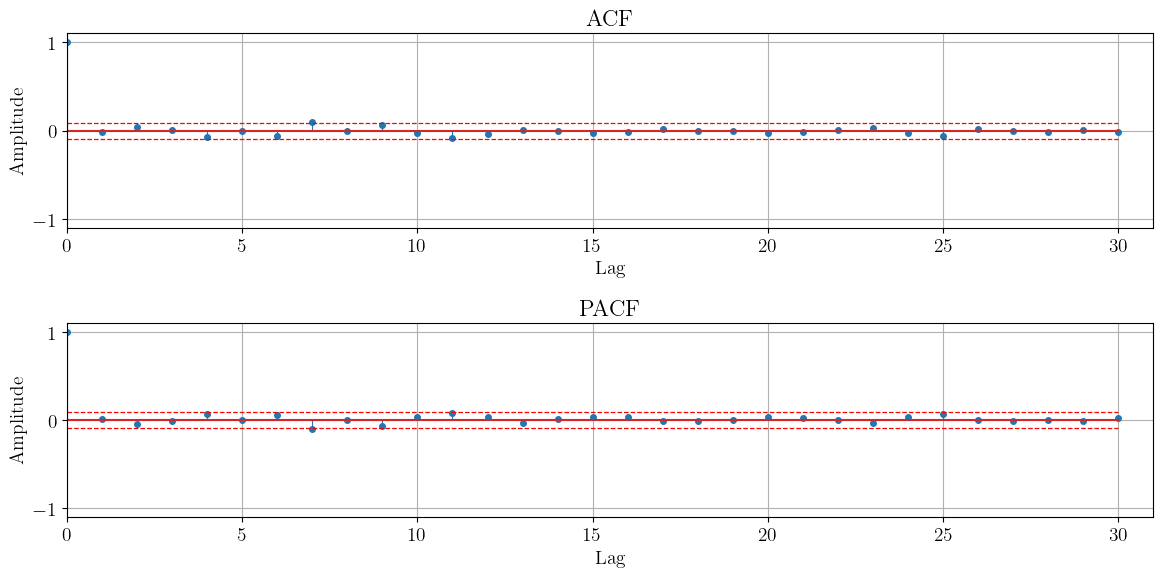

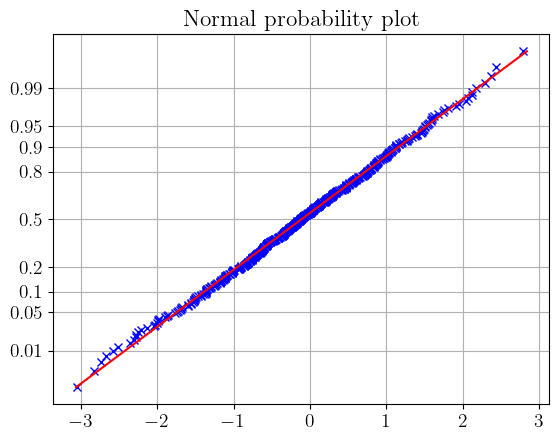

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.33 < 37.65)
  McLeod-Li test:        True (white if 31.85 < 37.65)
  Monti test:            True (white if 22.34 < 37.65)
  Sign change test:      True (white if 0.46 in [0.45,0.55])


In [63]:
# Try and have the differentiation in the A() polynomial
# Unsure how this part works 


# Estimate ARMA(2, 12) with only c_12 free (c_1 through c_11 fixed at 0)
# We specify which C coefficients are free to be estimated
C_free = np.array([1] + [0]*11 + [1])  # c_0 and c_12 are free (c_0 is always 1)
A_free = np.array([1, 1, 1])
A12_free = np.array([1] + [0]*11 + [1])
Astar_free = np.convolve(A_free, A12_free)
print(Astar_free)


model_arma = estimateARMA(y_s, A=14, C=12, A_free=Astar_free, C_free=C_free, plot=False)
model_arma.summary()

# Compute residuals
e_hat_arma = my_filter(model_arma.A, model_arma.C, y_s)

# Analyze residuals
plotACFnPACF(e_hat_arma, noLags=30, signLvl=0.05)
normplot(e_hat_arma)
whiteness_test(e_hat_arma, alpha=0.05)

## 2.4 Estimation on real data

We now proceed to use our knowledge on estimation of SARIMA-models on real data. Load the temperature measurements from Svedala. Using the working order stated above, create a suitable model for this data. Remember to reestimate all your parameters if you change your model.

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'svedala'])
Loaded 1361 temperature measurements
Data shape: (1361,)


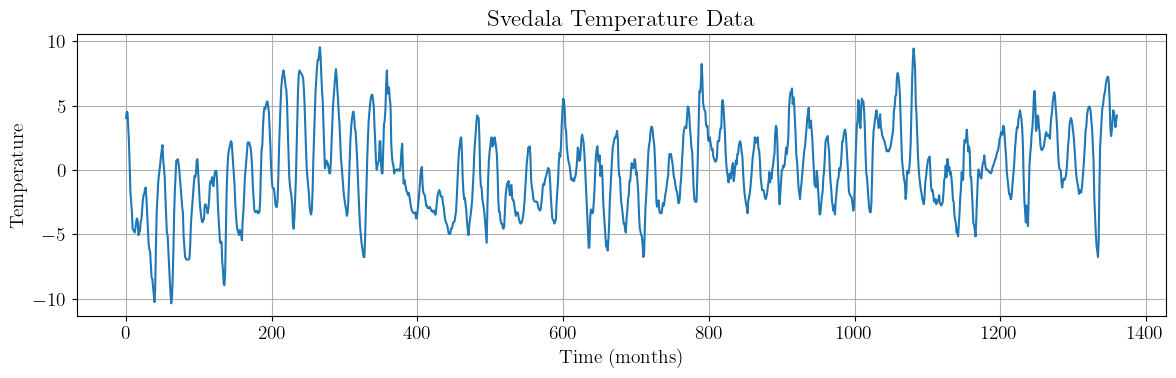

In [60]:
# Load Svedala temperature data
svedala_file = '../data/svedala.mat'
mat_data = scipy.io.loadmat(svedala_file)

print("Keys in .mat file:", mat_data.keys())

svedala = mat_data['svedala'].flatten()

print(f"Loaded {len(svedala)} temperature measurements")
print(f"Data shape: {svedala.shape}")

# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(svedala)
plt.title('Svedala Temperature Data')
plt.xlabel('Time (months)')
plt.ylabel('Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

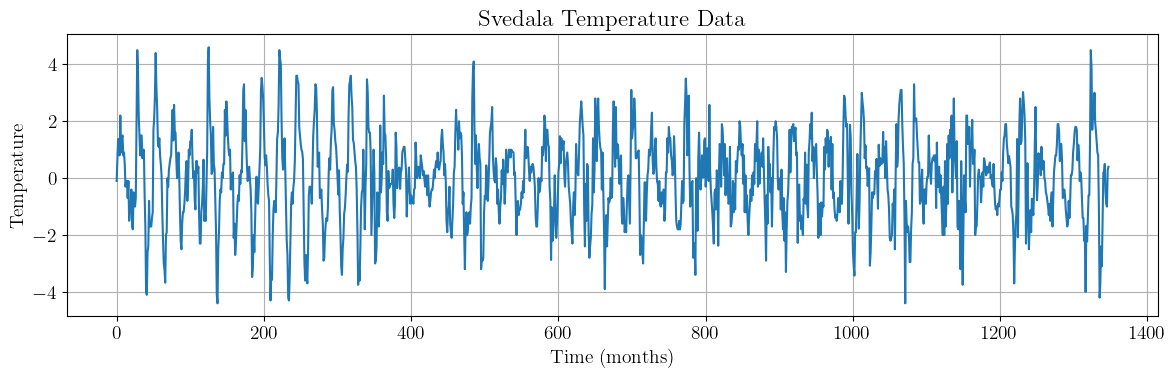

In [105]:
# estimate a model for the Svedala data

# Try first to just directly differentiate 
C = np.array([1])
A12 = np.array([1] + [0]*11 + [-1])
A1 = np.array([1, -1])
A = np.convolve(A1, A12)
svedala_s = my_filter(A, C, svedala)

# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(svedala_s)
plt.title('Svedala Temperature Data')
plt.xlabel('Time (months)')
plt.ylabel('Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.2884(±0.2783)·z⁻¹ - 0.2371(±0.1974)·z⁻² - 0.0428(±0.0286)·z⁻³
C(z) = 1.0 + 0.4038(±0.2776)·z⁻¹ - 0.9217(±0.0106)·z⁻¹² - 0.3491(±0.2594)·z⁻¹³

Polynomial orders: nA = 3    nC = 13
Number of free coefficients: 6
Fit to estimation data (NRMSE): 55.09%
FPE : 0.464  MSE : 0.46
AIC : 2785.16   BIC : 2816.385



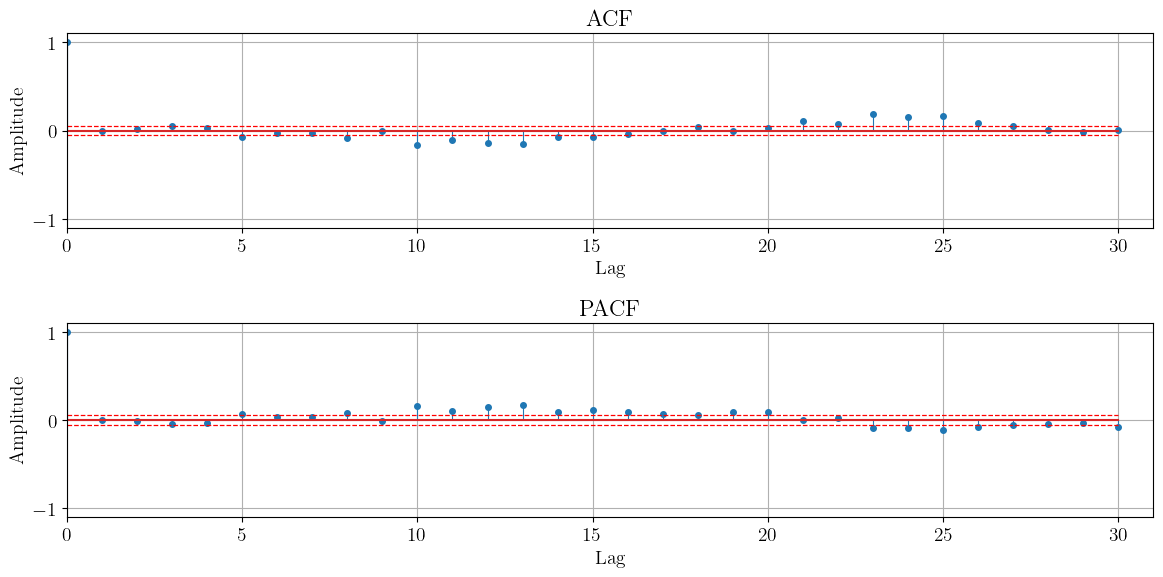

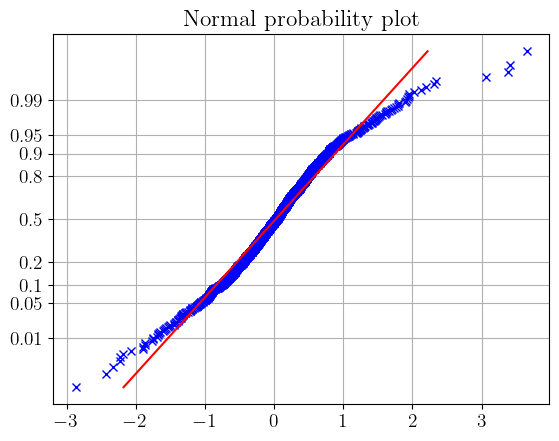

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 292.67 < 37.65)
  McLeod-Li test:        False (white if 85.98 < 37.65)
  Monti test:            False (white if 256.73 < 37.65)
  Sign change test:      True (white if 0.50 in [0.47,0.53])


In [107]:
# Experiment to find a model, either differentiated on its own or as part of the estimation 

C_free = np.array([1, 1] + [0]*10 + [1, 1])
#Af = np.array([1, 1, 1])
#A12f = np.array([1] + [0]*11 + [1])
#A_free = np.convolve(Af, A12f)
model_arma = estimateARMA(svedala_s, A=3, C=13, C_free=C_free, plot=False)
model_arma.summary()

# Compute residuals
e_hat_arma = my_filter(model_arma.A, model_arma.C, svedala_s)

# Analyze residuals
plotACFnPACF(e_hat_arma, noLags=30, signLvl=0.05)
normplot(e_hat_arma)
whiteness_test(e_hat_arma, alpha=0.05)

### Basic analysis of Svedala data

In [ ]:
# do some basic analysis on the data

In [ ]:
# Do some modeling 

### Examination Question 6

**In Mozquizto, answer question 6.**

What parameter estimates did you get? 

Can you improve the model by not differentiating the data? Why or why not?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

### Discussion: What parameter estimates did you get? Can you improve the model by not differentiating the data? Why or why not?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

## 2.5 (optional) Examine the project data

Why not now load the project data and try to build an ARMA model for the output data? 

Can you make the model residual white without using too many parameters? 

Do you have insignificant parameters in the model? 

Examine the variance of the model residual for the different models - do you need to include all parameters or can you remove some without increasing the variance noticeably while retaining an "almost" white residual?

**Hint:** The above steps will typically be the first part of your work on the project, so the time you spend on this now will be time saved later on...